In [1]:
import os
import sys
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

In [2]:
comet_api = API(api_key = os.environ['COMET_ML_API_KEY'])
metrics = []
min_mape = []
IDs = []
experiments = comet_api.get(workspace='danielelinaro', project_name='inertia')
for experiment in experiments:
    IDs.append(experiment.id)
    print(f'Downloading metrics for experiment ID {IDs[-1][:9]}.')
    metrics.append(experiment.get_metrics())
    mape = [float(m['metricValue']) for m in metrics[-1] if m['metricName'] == 'mape_prediction']
    if len(mape) > 0:
        min_mape.append(mape[0])
    else:
        min_mape.append(np.max(min_mape) * 10)
best_experiment = np.argmin(min_mape)
best_experiment_ID = IDs[best_experiment]
print(f'The best experiment is {best_experiment_ID[:9]} (MAPE = {min_mape[best_experiment]:.2f}%).')

The best experiment is f0dc559c1 (MAPE = 0.54%).


In [3]:
experiments_path = '../experiments/'
checkpoint_path = experiments_path + best_experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + best_experiment_ID + '/parameters.pkl', 'rb'))
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
model = keras.models.load_model(best_checkpoint, compile=True)
data_dir = '../' + network_parameters['data_dir']
print('Loaded network from {}.'.format(best_checkpoint))
print('Data directory is {}.'.format(data_dir))

Loaded network from ../experiments/f0dc559c19584ecb82668b0f585819e8/checkpoints/weights.678-0.02.h5.
Data directory is ../data/IEEE14_D=2_DZA=60.0.


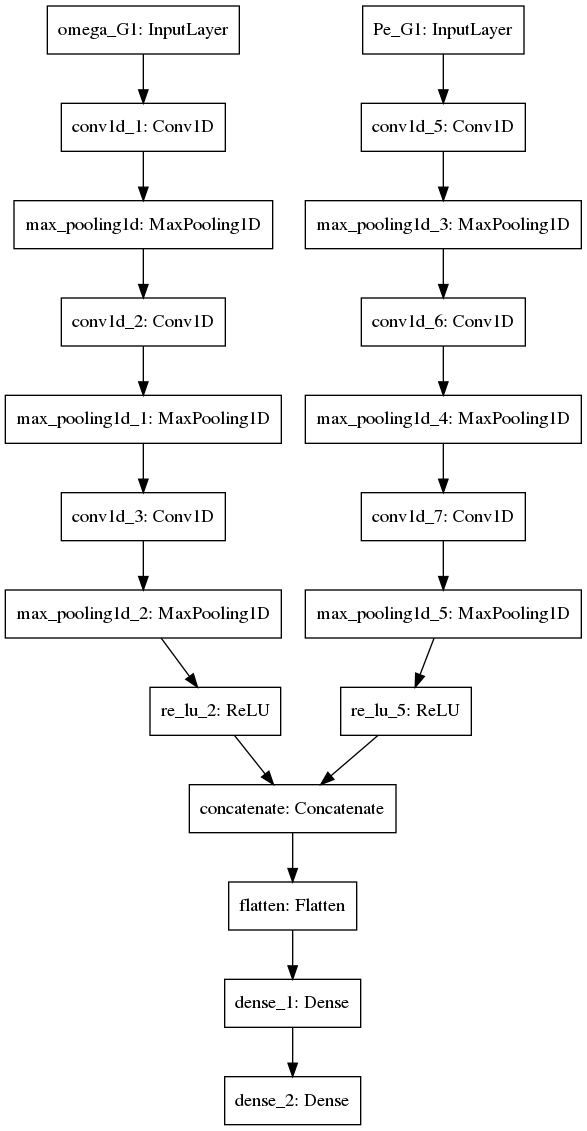

In [4]:
keras.utils.plot_model(model)

In [5]:
var_names = network_parameters['var_names']
n_vars = len(var_names)
inertia = {'test': np.arange(2,11) + 1/3}
time, x, y = load_data(data_dir, inertia, var_names)
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
x['test'] = tf.constant([(x['test'][i].numpy() - m) / s for i,(m,s) in enumerate(zip(x_train_mean, x_train_std))])

In [6]:
def plot_outputs(data, var_name, N_blocks, N_layers_per_block, step, ax = None, w = 4, h = 3):
    if var_name == 'omega_G1':
        k = 0
    else:
        k = 1
    X = model.layers[k].call(data)
    k += step
    if ax is None:
        fig,ax = plt.subplots(N_blocks, N_layers_per_block, figsize=(N_layers_per_block * w, N_blocks * h))
    for i in range(N_blocks):
        for j in range(N_layers_per_block):
            try:
                X = model.layers[k].call(X[var_name])
            except:
                X = model.layers[k].call(X)
            k += step
            ax[i,j].imshow(np.squeeze(X).T, aspect='auto', cmap='jet')
            ax[i,j].set_xticks([0, X.shape[1] - 1])
            ax[i,j].set_yticks([0, X.shape[2] - 1])

In [7]:
N_blocks = 3
N_layers_per_block = 2
step = 2
w = 3
h = 2

H = 2.333 -> prediction = 2.264


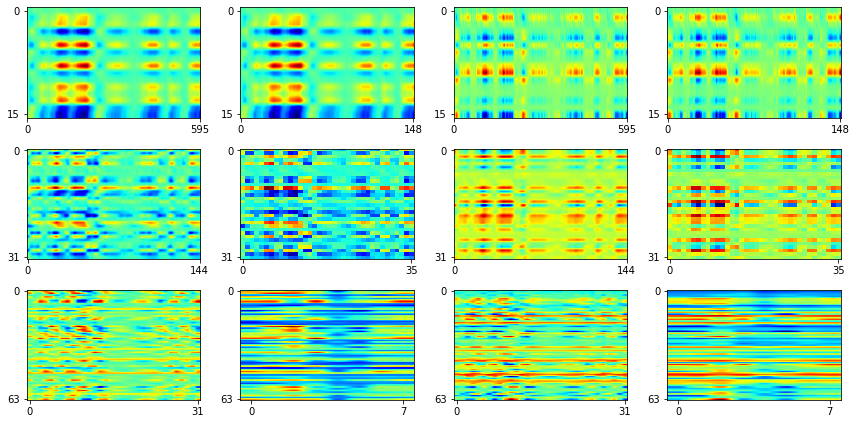

In [8]:
idx = 0
data = {var_name: x['test'][i, idx, :][np.newaxis, :, np.newaxis] for i,var_name in enumerate(var_names)}

H = y['test'][idx,0].numpy()
H_prediction = model.call(data)[0,0].numpy()
print(f'H = {H:.3f} -> prediction = {H_prediction:.3f}')

fig,ax = plt.subplots(N_blocks, N_layers_per_block * 2, figsize=(N_layers_per_block * w * 2, N_blocks * h))

for i,var_name in enumerate(var_names):
    plot_outputs(data[var_name], var_name, N_blocks, N_layers_per_block, step, ax[:,i*2:(i+1)*2])
fig.tight_layout()

H = 10.333 -> prediction = 10.344


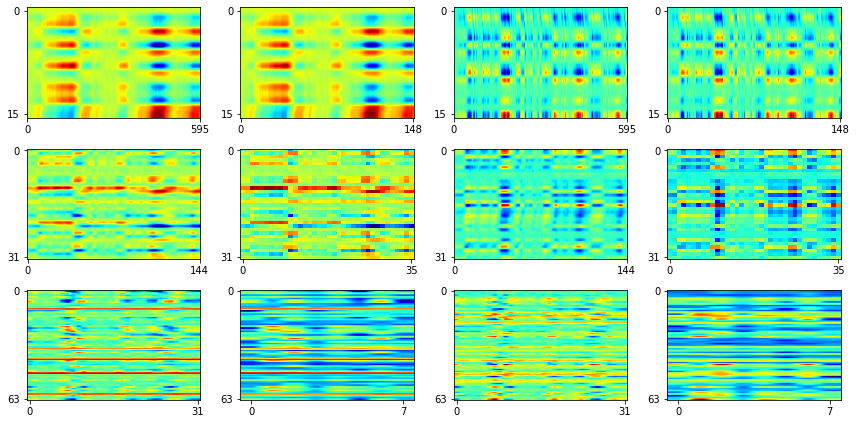

In [13]:
idx = 4400
data = {var_name: x['test'][i, idx, :][np.newaxis, :, np.newaxis] for i,var_name in enumerate(var_names)}

H = y['test'][idx,0].numpy()
H_prediction = model.call(data)[0,0].numpy()
print(f'H = {H:.3f} -> prediction = {H_prediction:.3f}')

fig,ax = plt.subplots(N_blocks, N_layers_per_block * 2, figsize=(N_layers_per_block * w * 2, N_blocks * h))

for i,var_name in enumerate(var_names):
    plot_outputs(data[var_name], var_name, N_blocks, N_layers_per_block, step, ax[:,i*2:(i+1)*2])
fig.tight_layout()